## Imports

In [17]:
import pandas as pd 
import numpy as np 

import spacy
from spacy import displacy

import networkx as nx 
import matplotlib.pyplot as plt
from pyvis.network import Network
import community as community_louvain


In [ ]:
#in order to use spacy we have to download en_core_web_sm using the following commmand:
# ~\anaconda3\envs\cote\python.exe python3 -m spacy download en_core_web_sm


NER = spacy.load("en_core_web_lg")

## Load books


In [1]:
import os

books = [book for book in os.scandir('../text files') if '.txt' in book.name]
books.sort(key=lambda x:x.name)
books

[<DirEntry '01 cote_1.txt'>,
 <DirEntry '02 cote_2.txt'>,
 <DirEntry '03 cote_3.txt'>,
 <DirEntry '04 cote_4.txt'>,
 <DirEntry '05 cote_4-5.txt'>,
 <DirEntry '06 cote_5.txt'>,
 <DirEntry '07 cote_6.txt'>,
 <DirEntry '08 cote_7.txt'>,
 <DirEntry '09 cote_7-5.txt'>,
 <DirEntry '10 cote_8.txt'>,
 <DirEntry '11 cote_9.txt'>,
 <DirEntry '12 cote_10.txt'>,
 <DirEntry '13 cote_11.txt'>,
 <DirEntry '14 cote_11-5.txt'>,
 <DirEntry '15 cote_11-75.txt'>]

## using NER
    

In [ ]:
book = books[0]
book_text = open(book, encoding='utf-8').read()
book_NER = NER(book_text)

In [ ]:
displacy.render(book_NER[0:2000], style='ent', jupyter=True)

## creating characters per sentence dataframe


In [ ]:
sentence_entity_df = []

for sentence in book_NER.sents:
    ent_list = [ent.text for ent in sentence.ents]
    sentence_entity_df.append({
        "sentence": sentence,
        "entities":ent_list
    })
sentence_entity_df = pd.DataFrame(sentence_entity_df)
sentence_entity_df

Filtering function

In [ ]:
# creating a filter to apply to our entities
def filter_entity(ent_list, character_df):
    characters = []
    for ent in ent_list:
        ent = str(ent)
        # in japan these are common suffixes
        ent = ent.replace('-san', '')
        ent = ent.replace('-kun', '')
        ent = ent.replace('-chan', '')
        ent = ent.replace('-sensei', '')
        if ent in list(character_df['character']) or ent in list(character_df['firstname']) or ent in list(character_df['lastname']) or ent in list(character_df['character reverse']):
            idx =  character_df.index[character_df['character'] == ent].tolist()+ character_df.index[character_df['firstname'] == ent].tolist() + character_df.index[character_df['lastname'] == ent].tolist() + character_df.index[character_df['character reverse'] == ent].tolist()
            if idx:
                idx = idx[0]
            characters.append(character_df['character'][idx])
    return characters

Filtered sentence entity df

In [ ]:
character_df = pd.read_csv('../data scraping/characters.csv')
sentence_entity_df["character_entities"] = sentence_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

#removing rows that dont have character entities
sentence_entity_df_filtered = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]
sentence_entity_df_filtered

## extracting relationships

In [ ]:
window_size = 10
relations = []

for i in range(sentence_entity_df_filtered.index[-1]):
    end_i = min(i+window_size, sentence_entity_df_filtered.index[-1])
    char_list = (sum((sentence_entity_df_filtered.loc[i:end_i].character_entities), []))
    
    # remove duplicate values in the char_list
    char_uniques = [char_list[i] for i in range(len(char_list))
                    if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_uniques) > 1:
        for idx, char in enumerate(char_uniques[:-1]):
            target = char_uniques[idx + 1]
            relations.append({
                "source":char,
                "target": target
            })
relations_df = pd.DataFrame(relations)
relations_df  


Relations dataframe

In [ ]:
pd.set_option('display.max_rows', None)
relations_df = pd.DataFrame(np.sort(relations_df.values, axis = 1), columns=relations_df.columns)
relations_df

Adding weights to the relations graph

In [ ]:
# init a new value column to all 1's
relations_df['value'] = 1

# aggregate over all source, target pairs, making value become the count
relations_df = relations_df.groupby(['source', 'target'], sort=False, as_index=False).sum()
relations_df

## Graph data analysis

creating graph

In [ ]:
G = nx.from_pandas_edgelist(relations_df,
                            source = "source", 
                            target = "target", 
                            edge_attr= "value", 
                            create_using=nx.Graph)



Networkx visualization

In [ ]:
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='purple', edge_cmap = plt.cm.Blues,  pos = pos)

Interactive graph visualization

In [ ]:
from pyvis.network import Network
network = Network(notebook=True)

node_degree = dict(G.degree)

network.from_nx(G)
nx.set_node_attributes(G, node_degree, 'size')

network.show("cote_0.html")

## Character importance


In [ ]:
# degree centrality
degree_centrality_dict = nx.degree_centrality(G)
degree_centrality_dict

In [ ]:
#sorting and plotting
degree_df = pd.DataFrame.from_dict(degree_centrality_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[0:10].plot(kind='bar')

In [ ]:
# betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)

betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[0:10].plot(kind='bar')

In [ ]:
# closeness centrality
closeness_dict = nx.betweenness_centrality(G)

closeness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[0:10].plot(kind='bar')

In [ ]:
# adding centrality measures as node attributes
nx.set_node_attributes(G, degree_centrality_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

## Clustering


In [ ]:
import community as community_louvain

In [ ]:
communities = community_louvain.best_partition(G)
communities

In [ ]:
nx.set_node_attributes(G, communities, 'group')

In [ ]:
colored_net = Network(notebook=True)
colored_net.from_nx(G)
colored_net.show('cote_0.html')

## Character importance over time


In [2]:
# importing our own defined functions
from lib.functions import *

In [20]:
character_df = pd.read_csv('../data scraping/characters.csv')
japanese_character_df = pd.read_csv('../data scraping/japanese characters.csv')
graphs = []
for book in books:

    #create ner object
    book_ner = ner(book)
    
    #get ne list per sentence
    sentence_entity_df = create_entity_per_sentence_df(book_ner)
    
    #filtering
    sentence_entity_df["character_entities"] = sentence_entity_df['entities'].apply(lambda x: filter_character_entities(x, character_df) + filter_character_entities(x, japanese_character_df))
    sentence_entity_df_filtered = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]
    
    #creating relationships 
    relations_df = create_relations(sentence_entity_df_filtered, window_size=5)
    
    #add graph to graph list
    G = nx.from_pandas_edgelist(relations_df,
                                source='source',
                                target='target', 
                                edge_attr='value',
                                create_using=nx.Graph())
    
    
    network = Network()
    
    
    node_degree = dict(G.degree)
    nx.set_node_attributes(G, node_degree, 'size')
    
    communities = community_louvain.best_partition(G)
    nx.set_node_attributes(G, communities, 'group')
    
    network.from_nx(G)
    network.save_graph(f"{book.name[:-4]}.html")
    graphs.append(G)
            
    
    

<Axes: >

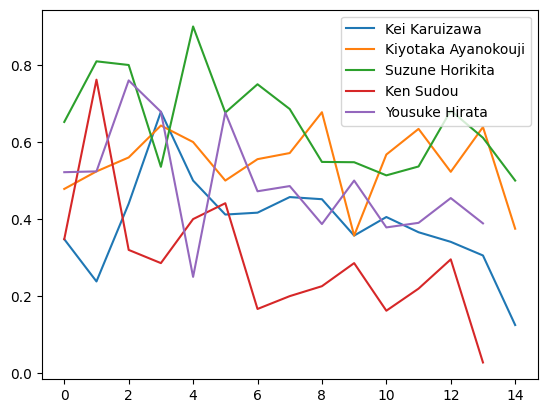

In [25]:
evol = [nx.degree_centrality(graph) for graph in graphs]
evol_df = pd.DataFrame(evol)
evol_df[["Kei Karuizawa", "Kiyotaka Ayanokouji", "Suzune Horikita", "Ken Sudou", "Yousuke Hirata"]].plot()
